# 3D Deconvolution Benchmark: Julia

---
## Setup

In [6]:
using DeconvOptim, Images, FFTW, Noise, ImageView, BenchmarkTools, Plots

---
## Test Image



In [106]:
img = convert(Array{Float32}, channelview(load("simple_3d_ball.tif")));

In [120]:
psf = ifftshift(convert(Array{Float32}, channelview(load("simple_3d_psf.tif"))));

In [108]:
# psf ./= sum(psf)
# # create a blurred, noisy version of that image
# img_b = conv(img, psf, [1, 2, 3])
# img_n = poisson(img_b, 300);
# save("simple_3d_ball_blurred.tif", img_n)

In [121]:
println("Max value in psf: ", maximum(psf))
println("Min value in psf: ", minimum(psf))

# Agregar un pequeño valor para evitar divisiones por cero
epsilon = eps(Float32)

# Asegurarse de que el PSF no tenga valores cero y normalizarlo
psf = psf .+ epsilon;
psf ./= sum(psf);


Max value in psf: 1.0
Min value in psf: 0.0


In [110]:
img_n = convert(Array{Float32}, channelview(load("simple_3d_ball_blurred.tif")));

In [111]:
println(size(img_n))
println("img_n element type: ", eltype(img_n))
println(size(psf))
println("psf element type: ", eltype(psf))

(64, 64, 64)
img_n element type: Float32
(64, 64, 64)
psf element type: Float32


In [112]:
reg = TV(num_dims=3, sum_dims=[1, 2, 3]);

In [113]:
res2 = richardson_lucy_iterative(img_n, psf, regularizer=reg, iterations=30);
println(size(res2))
println("res2 element type: ", eltype(res2))

(64, 64, 64)
res2 element type: Float32


In [114]:
@benchmark richardson_lucy_iterative(img_n, psf, regularizer=reg, iterations=30)  samples=100 evals=1

BenchmarkTools.Trial: 57 samples with 1 evaluation.
 Range (min … max):  84.689 ms … 91.357 ms  ┊ GC (min … max): 0.00% … 1.03%
 Time  (median):     86.982 ms              ┊ GC (median):    1.14%
 Time  (mean ± σ):   87.028 ms ±  1.465 ms  ┊ GC (mean ± σ):  1.03% ± 1.10%

   ▁▁     █  ▁ ▄▄ ▁  ▄ █▁ ▄▁ ▄  █ ▁                            
  ▆██▁▆▁▁▆█▆▁█▁██▆█▆▆█▁██▁██▁█▁▁█▆█▁▆▁▆▁▆▁▁▆▁▁▁▆▁▁▁▁▁▁▁▆▁▁▁▁▆ ▁
  84.7 ms         Histogram: frequency by time          91 ms <

 Memory estimate: 38.15 MiB, allocs estimate: 1894.

In [115]:
res = richardson_lucy_iterative(img_n, psf, regularizer=nothing, iterations=30);

println(size(res))
println("res element type: ", eltype(res))

(64, 64, 64)
res element type: Float32


In [116]:
@benchmark richardson_lucy_iterative(img_n, psf, regularizer=nothing, iterations=30) samples=100 evals=1 seconds=60

BenchmarkTools.Trial: 100 samples with 1 evaluation.
 Range (min … max):  45.966 ms …  51.688 ms  ┊ GC (min … max): 0.00% … 10.38%
 Time  (median):     46.249 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   46.481 ms ± 804.278 μs  ┊ GC (mean ± σ):  0.51% ±  1.57%

  ▄▂█▄▃▄▂                                                       
  ███████▇▃▁▃▃▃▃▁▁▁▁▁▁▁▁▁▁▅▄▁▃▁▁▃▄▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃ ▃
  46 ms           Histogram: frequency by time         49.9 ms <

 Memory estimate: 7.10 MiB, allocs estimate: 33.

In [117]:
# Verificar valores mínimos y máximos en las matrices resultantes
println("Max value in res2: ", maximum(res2))
println("Min value in res2: ", minimum(res2))
println("Max value in res: ", maximum(res))
println("Min value in res: ", minimum(res))
println("Max value in img_n: ", maximum(img_n))
println("Min value in img_n: ", minimum(img_n))


Max value in res2: 0.41446292
Min value in res2: -0.0
Max value in res: 0.5674032
Min value in res: 0.0
Max value in img_n: 0.2627451
Min value in img_n: 0.0


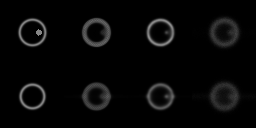

In [118]:
img_comb1 = [img[:, : ,32] res2[:, :, 32] res[:, :, 32] img_n[:, :, 32]]
img_comb2 = [img[:, : ,38] res2[:, :, 38] res[:, :, 38] img_n[:, :, 38]]

img_comb = cat(img_comb1, img_comb2, dims=1)
#img_comb ./= maximum(img_comb)

#imshow([img[:, :, 20:end] res2[:, :, 20:end] res[:, :, 20:end] img_n[:, :, 20:end]])
colorview(Gray, img_comb)

---
## Cell 3D

In [24]:
cell = convert(Array{Float32}, channelview(load("cells3d_convolved.tiff")));

In [25]:
cell_psf = convert(Array{Float32}, channelview(load("cells3d_psf.tiff")));

In [26]:
cell /= maximum(cell);
cell_psf /= maximum(cell_psf);

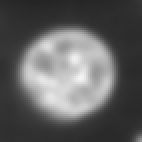

In [27]:
colorview(Gray, cell[:,:,30])

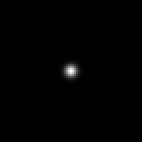

In [28]:
colorview(Gray, cell_psf[:,:,30])

In [29]:
cell_res, cell_ores = deconvolution(cell, ifftshift(cell_psf), regularizer=nothing, iterations=10);

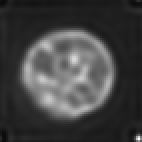

In [30]:
colorview(Gray, cell_res[:,:,30]/maximum(cell_res[:,:,30]))

In [31]:
@benchmark deconvolution(cell, ifftshift(cell_psf), regularizer=nothing, iterations=10) samples=100 evals=1 seconds=60

BenchmarkTools.Trial: 100 samples with 1 evaluation.
 Range (min … max):  427.467 ms … 577.024 ms  ┊ GC (min … max): 0.07% … 23.21%
 Time  (median):     431.148 ms               ┊ GC (median):    0.51%
 Time  (mean ± σ):   436.169 ms ±  20.120 ms  ┊ GC (mean ± σ):  1.16% ±  3.25%

  ▇█                                                             
  ███▃▄▃▄▄▄▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂ ▂
  427 ms           Histogram: frequency by time          563 ms <

 Memory estimate: 105.90 MiB, allocs estimate: 2196.

---
## Cube of Spherical Beads

In [4]:
# Cargamos la imagen

cube = convert(Array{Float32}, channelview(load("cubeConvolved.tif")));

# Cargamos la psf

cubePSF = convert(Array{Float32}, channelview(load("PSF.tif")));

cube /= maximum(cube);
cubePSF /= maximum(cubePSF);

Loading: 100%|███████████████████████████████████████████| Time: 0:00:00


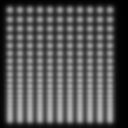

In [5]:
colorview(Gray, cube[:,:,30])

In [6]:
number_of_iterations = 30

cube_res, cube_ores = deconvolution(cube, ifftshift(cubePSF), regularizer=nothing, iterations=number_of_iterations);

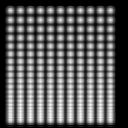

In [39]:
colorview(Gray, cube_res[:,:,30]/maximum(cube_res[:,:,30]))

In [8]:
deconCube = richardson_lucy_iterative(cube, ifftshift(cubePSF), regularizer=nothing, iterations=number_of_iterations);

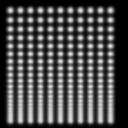

In [9]:
colorview(Gray, deconCube[:,:,30]/maximum(cube_res[:,:,30]))

In [64]:
@benchmark richardson_lucy_iterative(cube, ifftshift(cubePSF), regularizer=nothing, iterations=number_of_iterations) samples=10 evals=1

BenchmarkTools.Trial: 7 samples with 1 evaluation.
 Range (min … max):  628.420 ms … 637.643 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     629.719 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   630.658 ms ±   3.137 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █    ██ ██  █                                               █  
  █▁▁▁▁██▁██▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  628 ms           Histogram: frequency by time          638 ms <

 Memory estimate: 64.38 MiB, allocs estimate: 37.

---
## C. elegans embryo

In [2]:
import Pkg;

Pkg.add("FileIO")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/TFGNotebook/Project.toml`
  No Changes to `~/TFGNotebook/Manifest.toml`


In [2]:
using FileIO
using Images

function load_image_stack(folder_path::String)
    # Listar todos los archivos en la carpeta y ordenar
    files = sort(filter(f -> endswith(f, ".tif") || endswith(f, ".png") || endswith(f, ".jpg"), readdir(folder_path)))

    # Leer la primera imagen para obtener las dimensiones
    first_image = load(joinpath(folder_path, files[1]))
    height, width = size(first_image)

    # Crear una matriz 3D vacía para almacenar las imágenes
    image_stack = Array{Float32, 3}(undef, length(files), height, width)

    # Cargar cada imagen en la matriz 3D y convertir a Float32
    for (i, file) in enumerate(files)
        image = load(joinpath(folder_path, file))
        image_stack[i, :, :] = float(image)
    end

    return image_stack
end


load_image_stack (generic function with 1 method)

### Canal 1

In [85]:
# Ruta a la carpeta que contiene las imágenes Z-stack
imagePath = "/Users/yi/TFGNotebook/CElegans-CY3"
psfPath = "/Users/yi/TFGNotebook/PSF-CElegans-CY3"

# Cargar las imágenes en una matriz 3D
image_stack = load_image_stack(imagePath)[:, 1:356, 1:336]
psf_stack = load_image_stack(psfPath)[:, 179:534, 169:504] #mitad +152

#save("imagenOriginal_CANAL1.png", image_stack[52, :, :]/maximum(image_stack[52,:,:]))

# Verificar las dimensiones de las matrices 3D
println(size(image_stack))
println("image_stack element type: ", eltype(image_stack))
println(size(psf_stack))


(104, 356, 336)
image_stack element type: Float32
(104, 356, 336)


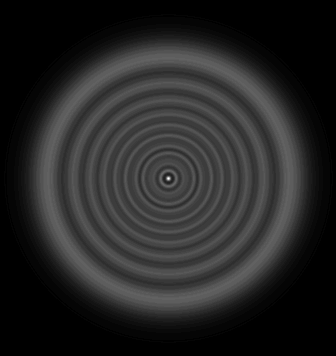

In [4]:
colorview(Gray, psf_stack[1,:,:]/maximum(psf_stack[1,:,:]))

In [10]:
num_iter = 150

canal1_res = richardson_lucy_iterative(image_stack, ifftshift(psf_stack), regularizer=nothing, iterations=num_iter);

In [36]:
# Verificar las dimensiones y tipo de canal1_res
println("Tipo de canal1_res: ", typeof(canal1_res))
println("Dimensiones de canal1_res: ", size(canal1_res))


Tipo de canal1_res: Array{Float32, 3}
Dimensiones de canal1_res: (104, 356, 336)


In [75]:
colorview(Gray, canal1_res[52,:,:]/maximum(canal1_res[52,:,:]))

save("deconvolved_CElegans_Julia_CANAL1arriba.png", canal1_res[52,:,:]/maximum(canal1_res[52,:,:]))

In [23]:
@benchmark richardson_lucy_iterative(image_stack, ifftshift(psf_stack), regularizer=nothing, iterations=150) samples=1

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 66.445 s (0.00% GC) to evaluate,
 with a memory estimate of 382.38 MiB, over 35 allocations.

### Canal 2

In [86]:
# Ruta a la carpeta que contiene las imágenes Z-stack
imagePath2 = "/Users/yi/TFGNotebook/CElegans-DAPI"
psfPath2 = "/Users/yi/TFGNotebook/PSF-CElegans-DAPI"

# Cargar las imágenes en una matriz 3D
image_stack2 = load_image_stack(imagePath2)[:, 1:356, 1:336]
psf_stack2 = load_image_stack(psfPath2)[:, 179:534, 169:504] #mitad +152

#save("imagenOriginal_CANAL2.png", image_stack2[52, :, :]/maximum(image_stack2[52,:,:]))

# Verificar las dimensiones de las matrices 3D
println(size(image_stack2))
println("image_stack element type: ", eltype(image_stack2))
println(size(psf_stack2))

(104, 356, 336)
image_stack element type: Float32
(104, 356, 336)


In [16]:
num_iter1= 200
canal2_res = richardson_lucy_iterative(image_stack2, ifftshift(psf_stack2), regularizer=nothing, iterations=num_iter1);


In [43]:
colorview(Gray, canal2_res[52,:,:]/maximum(canal2_res[52,:,:]))

#save("deconvolved_CElegans_Julia_CANAL12.png", canal2_res[52,:,:]/maximum(canal2_res[52,:,:]))

In [36]:
@benchmark richardson_lucy_iterative(image_stack2, ifftshift(psf_stack2), regularizer=nothing, iterations=200) samples=1

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 88.195 s (0.00% GC) to evaluate,
 with a memory estimate of 382.38 MiB, over 35 allocations.

### Canal 3

In [87]:
# Ruta a la carpeta que contiene las imágenes Z-stack
imagePath3 = "/Users/yi/TFGNotebook/CElegans-FITC"
psfPath3 = "/Users/yi/TFGNotebook/PSF-CElegans-FITC"

# Cargar las imágenes en una matriz 3D
image_stack3 = load_image_stack(imagePath3)[:, 1:356, 1:336]
psf_stack3 = load_image_stack(psfPath3)[:, 179:534, 169:504] #mitad +152

#save("imagenOriginal_CANAL3.png", image_stack3[52, :, :]/maximum(image_stack3[52,:,:]))

# Verificar las dimensiones de las matrices 3D
println(size(image_stack3))
println("image_stack element type: ", eltype(image_stack3))
println(size(psf_stack3))

(104, 356, 336)
image_stack element type: Float32
(104, 356, 336)


In [18]:
canal3_res = richardson_lucy_iterative(image_stack3, ifftshift(psf_stack3), regularizer=nothing, iterations=200);

In [44]:
colorview(Gray, canal3_res[52,:,:]/maximum(canal3_res[52,:,:]))

save("deconvolved_CElegans_Julia_CANAL3.png", canal3_res[52,:,:]/maximum(canal3_res[52,:,:]))

In [49]:
@benchmark richardson_lucy_iterative(image_stack3, ifftshift(psf_stack3), regularizer=nothing, iterations=200) samples=1

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 88.196 s (0.00% GC) to evaluate,
 with a memory estimate of 382.38 MiB, over 35 allocations.

### Combinación de canales

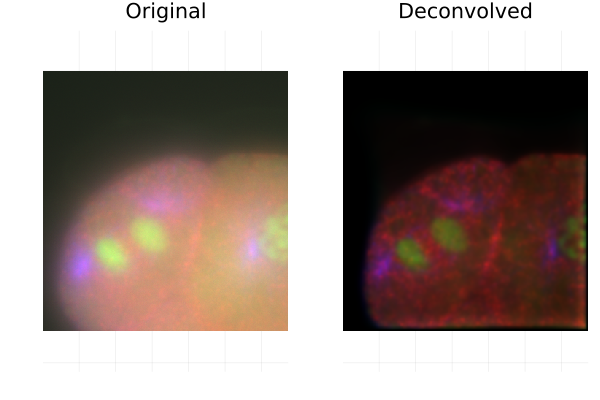

In [79]:
using Plots
using Images
using ColorTypes

# Función para normalizar una imagen
function normalize(image::AbstractArray)
    max_val = maximum(image)
    return (image) ./ (max_val)
end

# Normalizar los canales
deconvolved_stack_R = normalize(canal1_res)
deconvolved_stack_G = normalize(canal2_res)
deconvolved_stack_B = normalize(canal3_res)

# Crear una imagen RGB para la visualización
function create_rgb_image(r::AbstractArray, g::AbstractArray, b::AbstractArray)
    # Verificar que todas las dimensiones sean iguales
    height, width = size(r)
    if size(g) != (height, width) || size(b) != (height, width)
        throw(ArgumentError("Las dimensiones de las imágenes R, G y B deben coincidir."))
    end

    # Crear una matriz de imágenes RGB
    rgb_image = Array{RGB{Float32}, 2}(undef, height, width)
    rgb_image[:, :] .= RGB{Float32}[RGB(r[i, j], g[i, j], b[i, j]) for i in 1:height, j in 1:width]
    return rgb_image
end

# Combinar los canales en una imagen RGB
deconvolved_image_color = create_rgb_image(deconvolved_stack_R[52, :, :],
                                           deconvolved_stack_G[52, :, :],
                                           deconvolved_stack_B[52, :, :])

# Normalizar y combinar los planos para la visualización
original_image_rgb = create_rgb_image(normalize(image_stack[52, :, :]),
                                       normalize(image_stack2[52, :, :]),
                                       normalize(image_stack3[52, :, :]))

# Guardar la imagen deconvolucionada en PNG
#save("deconvolved_CElegans_Julia.png", deconvolved_image_color)
save("deconvolved_CElegans_Julia_CANAL1.png", deconvolved_stack_R[52, :, :])
# Mostrar las imágenes
plot(
    heatmap(original_image_rgb, title="Original", axis=false, color=:viridis),
    heatmap(deconvolved_image_color, title="Deconvolved", axis=false, color=:viridis),
    layout=(1, 2)
)

#save("deconvolved_CElegans_Julia_CANAL1.png", deconvolved_stack_R[52, :, :])
